In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [3]:
for module in ['hosts', 'targeting', 'magellan']:
    if module in globals():
        reload(globals()[module])
    else:
        globals()[module] = __import__(module)
#g = targeting.get_gama() #re-caches the gama catalog

In [4]:
hostlst = hosts.get_saga_hosts_from_google('etollerud', )

Using cached version of google hosts list from file "hosts_dl.pkl"


In [190]:
from astropy import table
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord

# Aeneid 

In [6]:
aen = [h for h in hostlst if h.name.lower() == 'aeneid'][0]
aen.shortname = 'Ae15B'

## First load the base catalog for targeting  and select from it

In [292]:
aencatall = aen.load_and_reprocess_sdss_catalog('catalogs/base_sql_nsa148734.fits.gz')
aencat = aencatall[aencatall['REMOVE']==-1]
aencat

objID,ra,dec,flags,specObjID,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,Au,Ag,Ar,Ai,Az,fibermag_r,fiber2mag_r,expRad_r,sb_exp_r,petroR50_r,petroR90_r,petroMag_r,sb_petro_r,J,Jerr,H,Herr,K,Kerr,w1,w1err,w2,w2err,spec_z,spec_z_err,spec_z_warn,photoz,photoz_err,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_REPEAT,U,B,V,R,I,rhost,rhost_kpc,type,phot_sg
int64,float64,float64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,int64,int64,str33,float64,float64,int64,int64,int64,str4,str33,float64,str33,float32,float32,float32,float32,float32,float64,float64,int16,str6
1237652935103480140,309.729008176,-5.63703653779,105587779178512,0,22.9579,20.7425,20.3556,20.263,20.1273,0.484098,0.0390553,0.0393113,0.0512199,0.185151,0.29302,0.215601,0.156372,0.118572,0.0840692,18.3269,19.1775,0.271209,19.5175474036,0.549493,1.03256,20.4749,21.1701822601,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,-1.0,-1.0,-1,0.032646,0.053939,309.727,-5.63998,52.1952,3900.01,9.594,148734,554,Aeneid,0.213466716794,3.24105837693,-1,-1,-1,,,-1.0,,21.6196,21.0826,20.5079,20.2244,19.8136,0.00354630317964,3.21148081354,3,GALAXY
1237652935103480156,309.729015174,-5.63294356656,123214324961296,0,22.0388,21.5081,21.5605,21.406,21.1318,0.224517,0.0640926,0.0977244,0.127903,0.42651,0.293641,0.216058,0.156703,0.118823,0.0842473,19.4841,20.304,0.378907,21.448604689,0.557706,0.978802,21.72,22.4474627256,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,-1.0,-1.0,-1,0.045518,0.017622,309.727,-5.63998,52.1952,3900.01,9.594,148734,554,Aeneid,0.43899790968,6.66529129713,-1,-1,-1,,,-1.0,,21.139,21.7107,21.5217,21.4199,20.9032,0.0073111156835,6.62084050736,3,GALAXY
1237652935103480169,309.727182786,-5.62738203082,35253394739472,0,24.2069,23.5105,21.8909,20.9998,20.5112,0.851696,0.257265,0.0962495,0.0683553,0.207094,0.29448,0.216675,0.157151,0.119163,0.0844879,21.5475,22.2121,0.0823311,18.4669198685,0.483909,1.11942,21.9425,22.3617977966,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,17.4149,0.16286,9999.0,9999.0,-1.0,-1.0,-1,-1.0,-1.0,309.727,-5.63998,52.1952,3900.01,9.594,148734,554,Aeneid,0.755956940507,11.4776701177,-1,-1,-1,,,-1.0,,24.637,24.2365,22.5794,21.6375,20.4142,0.0125991340932,11.4095934155,6,STAR
1237652935103480174,309.732709357,-5.63773653869,105622138916880,0,23.9435,22.3289,22.0149,21.5972,20.9915,0.839658,0.107141,0.12051,0.128218,0.340936,0.293077,0.215643,0.156402,0.118595,0.0840855,20.7054,21.5378,0.226149,20.782359931,0.509742,0.952524,22.1542,22.6863931887,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,-1.0,-1.0,-1,0.071359,0.03848,309.727,-5.63998,52.1952,3900.01,9.594,148734,554,Aeneid,0.366516242461,5.56480445414,-1,-1,-1,,,-1.0,,22.8322,22.6461,22.1355,21.834,20.9664,0.00608940969262,5.51448125076,3,GALAXY
1237652935103480189,309.727839749,-5.65097077162,105622138917136,0,25.5967,23.6721,22.0869,21.8798,20.9249,0.594109,0.287097,0.110072,0.139482,0.284116,0.290894,0.214037,0.155237,0.117712,0.0834591,21.5846,22.3004,2.57311e-05,1.13467847717,0.41216,0.830086,22.2599,22.3306693135,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,21.2916,5.72654,9999.0,9999.0,-1.0,-1.0,-1,-1.0,-1.0,309.727,-5.63998,52.1952,3900.01,9.594,148734,554,Aeneid,0.661349785633,10.0412527215,-1,-1,-1,,,-1.0,,25.4082,24.3872,22.7605,21.9382,21.1142,0.0110208120873,9.98028785901,6,STAR
1237652935103480184,309.73514294,-5.64477048305,105622138916880,0,23.4756,23.4461,22.662,21.1312,19.9846,0.650023,0.272996,0.229442,0.0897261,0.150887,0.292229,0.215019,0.15595,0.118252,0.0838421,22.491,23.1006,0.433888,22.8442694694,0.531161,0.

## Now combine with the ML satellite probabilities 

In [293]:
#this is the OLD one, without WISE or AAT inputs.  Below we replace this with the new one
mlcat = Table.read('catalogs/Nsaid_148734_Prediction.txt.gz', format='ascii.commented_header')
mlcat

OBJID,RA,DEC,DERED_R,HOST_NSAID,HOST_SAGA_NAME,PROBABILITY_CLASS_1,BEST_GUESS_CLASS
int64,float64,float64,float64,int64,str6,float64,int64
1237652935640679317,310.48709773,-5.29903282208,17.8582,148734,Aeneid,0.703190495183,1
1237652599023075657,309.277627512,-6.25215596066,20.6097,148734,Aeneid,0.692727619747,1
1237652934566347493,308.998865433,-6.04259374486,16.9751,148734,Aeneid,0.678009290573,1
1237652935103414657,309.530485006,-5.55904228199,21.3017,148734,Aeneid,0.498684086896,0
1237652599023403992,310.02399615,-6.37997177161,16.5403,148734,Aeneid,0.461630804327,0
1237652599560471646,310.583739707,-5.91107630315,16.6271,148734,Aeneid,0.431334687942,0
1237652599559881170,309.236989388,-5.71399692322,21.6964,148734,Aeneid,0.394367554356,0
1237652935103283759,309.315312248,-5.47111305489,19.1434,148734,Aeneid,0.377974080296,0
1237652599559816057,309.052918228,-5.79614823946,17.5551,148734,Aeneid,0.355277270507,0


In [383]:
#there are two ML catalogs, one with WISE and the other without
mlcatwowise = Table.read('catalogs/SAGAobjidPrediction_SDSS_148724.fit')
mlcatwwise = Table.read('catalogs/SAGAobjidPrediction_SDSSwise_148724.fit')

#their OBJID columns are strings and are weirdly broken - need to fix:
for cat in (mlcatwowise, mlcatwwise):
    newoid = [int(i) for i in cat['OBJID']]
    del cat['OBJID']
    cat['OBJID'] = newoid
    
mlcatwowisetokeep = np.array([i not in mlcatwwise['OBJID'] for i in mlcatwowise['OBJID']])
mlcat = table.vstack((mlcatwwise, mlcatwowise[mlcatwowisetokeep]))
mlcat

RA,DEC,DERED_R,PROBABILITY_CLASS_1,BEST_GUESS_CLASS,RA_2,DEC_2,HOST_NSAID,HOST_SAGA_NAME,GroupID,GroupSize,Separation,OBJID
,,,,,,,,,,,arcsec,
float32,float32,float32,float32,int32,float64,float64,str22,str6,int32,int32,float64,int64
308.999,-6.04259,16.9751,0.912589,1,308.998836225,-6.04272276966,148734,Aeneid,1,8,0.480010198694,1237652934566347493
309.237,-5.714,21.6964,0.700115,1,309.212157944,-5.73670291961,148734,Aeneid,2,48,120.829533201,1237652599559881170
310.584,-5.91108,16.6271,0.670683,1,310.583718595,-5.91110495655,148734,Aeneid,3,14,0.129689438483,1237652599560471646
309.278,-6.25216,20.6097,0.601078,1,309.277627512,-6.25215596066,148734,Aeneid,4,34,0.0325855096457,1237652599023075657
310.29,-5.10096,15.4655,0.584263,1,310.290208273,-5.10095745073,148734,Aeneid,5,13,0.0498236896783,1237652600634081483
309.053,-5.79615,17.5551,0.55899,1,309.052918228,-5.79614823946,148734,Aeneid,6,27,0.00268583197661,1237652599559816057
310.491,-5.55188,15.8186,0.543916,1,310.491415408,-5.55187389302,148734,Aeneid,7,4,0.076796026605,1237652600097276470
309.53,-5.55904,21.3017,0.479454,0,309.529996725,-5.55818889378,148734,Aeneid,8,3,3.5396212337,1237652935103414657


In [399]:
#oh wait, now there's a catalog that's pre-combined them in a better way.  Use that.
mlcat = Table.read('catalogs/SAGAobjidMaxPrediction_148724.fit')
mlcat

OBJID,RA,DEC,DERED_R,PROBABILITY_CLASS_1,BEST_GUESS_CLASS,RA_2,DEC_2,HOST_NSAID,HOST_SAGA_NAME,GROUPID,GROUPSIZE,SEPARATION
str19,float32,float32,float32,float32,int32,float64,float64,str22,str6,int32,int32,float64
1237652598486205507,309.304,-6.53162,18.1611,0.00630723,0,309.315527052,-6.51527362412,148734,Aeneid,337,16,72.6463592797
1237652598486205712,309.287,-6.52735,18.7401,0.017282,0,309.285888875,-6.50752854953,148734,Aeneid,213,15,71.4392858465
1237652598486206390,309.273,-6.52482,21.6956,0.00629146,0,309.285888875,-6.50752854953,148734,Aeneid,30,28,77.576988043
1237652598486206421,309.281,-6.52509,20.6051,0.00666024,0,309.285888875,-6.50752854953,148734,Aeneid,30,28,65.9821048409
1237652598486206468,309.293,-6.53474,20.4377,0.00663706,0,309.285888875,-6.50752854953,148734,Aeneid,30,28,100.93140246
1237652598486270003,309.311,-6.53664,16.8172,0.00202179,0,309.315527052,-6.51527362412,148734,Aeneid,337,16,78.3727441071
1237652598486270043,309.322,-6.54969,18.5356,0.0131687,0,309.315527052,-6.51527362412,148734,Aeneid,398,27,125.854517801
1237652598486270356,309.404,-6.56146,21.3534,0.0132089,0,309.46721702,-6.58526689242,148734,Aeneid,90,72,240.480682401
1237652598486270373,309.42,-6.54551,20.374,0.0258796,0,309.46721702,-6.58526689242,148734,Aeneid,90,72,222.324141205


In [400]:
#now xmatch in the sense of ML things with matches in aencat
catsc = SkyCoord(aencat['ra'], aencat['dec'], unit=u.deg)
mlsc = SkyCoord(mlcat['RA'], mlcat['DEC'], unit=u.deg)

idxsc, d2d, _ = mlsc.match_to_catalog_sky(catsc)

(19765, 5, <Column name='PROBABILITY_CLASS_1' dtype='float32' length=5>
  0.0328935
 0.00810233
 0.00666758
 0.00377329
  0.0120457)

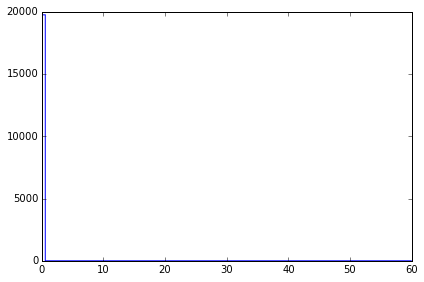

In [401]:
plt.hist(d2d.arcsec, bins=100, histtype='step',range=(0,60))
plt.tight_layout()
np.sum(d2d<1*u.arcsec),np.sum(d2d>1*u.arcsec), mlcat[d2d>1*u.arcsec]['PROBABILITY_CLASS_1']

In [402]:
#add probabilities to catalog
probs = -np.ones(len(aencat), dtype=float)  #-1 for those w/o
probs[idxsc[d2d<1*u.arcsec]] = mlcat['PROBABILITY_CLASS_1'][d2d<1*u.arcsec]

if 'ML_prob' in aencat.colnames:
    aencat['ML_prob'] = probs
else:
    aencat.add_column(Column(name='ML_prob', data=probs))

## Now Selection 

In [403]:
gricolorcuts = {'g-r': (None, 0.8, 2),
                'r-i': (None, 0.5, 2)}
sagacolorcuts = gricolorcuts.copy()
sagacolorcuts['r-K'] = (None, 2.0, 2)
sagacolorcuts['r-w1'] = (None, 2.6, 2)

def uggrline_cut(cat, sl=1.5, inter=-0.2):
    gt = cat['u']-cat['g']+2*(cat['u_err']+cat['g_err'])
    lt = sl*(cat['g']-cat['r']-2*(cat['g_err']+cat['r_err'])) + inter
    return gt > lt
sagacolorcuts['funcs'] = [uggrline_cut]

In [404]:
aen.environskpc

300.00000000000006

In [405]:
magcut = 22
aentargs = targeting.select_targets(aen, colorcuts=gricolorcuts, outercutrad=aen.environskpc*u.kpc, 
                                    galvsallcutoff=magcut, faintlimit=magcut, verbose=True,
                                    removespecstars=False, removegalsathighz =False,
                                    catalog=aencat) #do these because the fits catalogs don't have spec_class
len(aentargs)

Colorcut for g-r removed 45025 objects
Colorcut for r-i removed 46120 objects


1386

In [406]:
goodprob = 0.05
closegoodprob_aencatmsk = (aencat['ML_prob']>goodprob)&(aencat['rhost_kpc']<aen.environskpc)&(aencat['r']<magcut)
np.sum(aentargs['ML_prob']>goodprob), np.sum(closegoodprob_aencatmsk)

(21, 79)

In [407]:
#so need to add in the missing ones...
print(len(aentargs))
torem = aentargs['ML_prob']>goodprob # first remove them
aentargs = aentargs[~torem]
print(len(aentargs))
#then add them back in
aentargs = table.vstack((aentargs, aencat[closegoodprob_aencatmsk]))
print(len(aentargs))

1386
1365
1444


## And compute priorities 

In [408]:
pris = np.zeros(len(aentargs), dtype=int)
pris[aentargs['r']<22] = 4
pris[aentargs['r']<21.5] = 3
pris[aentargs['r']<21] = 2
pris[aentargs['ML_prob']>goodprob] = 1
if 'imacs_pri' in aentargs.colnames:
    aentargs['imacs_pri'] = pris
else:
    aentargs.add_column(Column(name='imacs_pri', data=pris))
np.bincount(pris)

array([  0,  79, 397, 326, 642])

# Identify previously-observed targets 

In [409]:
allspectaken = Table.read('SAGADropbox/data/allspectaken_v3.fits.gz')
allspectaken = allspectaken[allspectaken['HOST_NSAID'] == aen.nsaid]
allspectaken

objID,ra,dec,phot_sg,flags,specObjID,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,Au,Ag,Ar,Ai,Az,fibermag_r,fiber2mag_r,expRad_r,sb_exp_r,petroR50_r,petroR90_r,petroMag_r,sb_petro_r,J,Jerr,H,Herr,K,Kerr,w1,w1err,w2,w2err,spec_z,spec_z_err,spec_z_warn,photoz,photoz_err,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_REPEAT
int64,float64,float64,int16,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,int64,int64,str47,float64,float64,int64,int64,int64,str4,str47,float64,str47
1237652599560274145,310.050003311,-5.92954642732,3,35253360136720,713866206725040128,18.3178,16.1598,15.0727,14.5497,14.1125,0.0355272,0.00382081,0.00272626,0.00263317,0.00480615,0.281095,0.206827,0.150008,0.113747,0.0806478,16.9641,17.6036,4.30062,20.6220570028,4.83292,15.7779,15.0727,20.4891667858,14.164,0.073,13.269,0.079,12.781,0.059,11.4814,0.00138982,12.113,0.024,0.0451133,-1.0,0,0.104527,0.017398,309.727,-5.63998,52.1952,3900.01,9.594,148734,554,Aeneid,25.9586056905,394.124940047,21337,2,-1,NSA,sdss,4.0,
1237652934566543592,309.458202309,-6.09078689743,3,35219000397840,713886547690153984,15.8779,14.1272,13.3569,12.9615,12.7003,0.00776215,0.00196836,0.00182516,0.00184461,0.00280299,0.315206,0.231926,0.168212,0.12755,0.0904345,15.6009,16.3089,4.85324,19.1227839712,4.73322,15.0381,13.4715,18.8427648824,13.302,0.091,12.52,0.109,12.207,0.082,10.3706,0.00056898,11.092,0.023,0.0128386,-1.0,0,0.05606,0.023641,309.727,-5.63998,52.1952,3900.01,9.594,148734,554,Aeneid,31.4499469854,477.496885247,21347,2,-1,NSA,sdss,4.0,
1237652934566477855,309.254267802,-5.99707587055,3,1161153267503124,0,16.6899,14.721,13.8355,13.3811,13.0031,0.0187306,0.00260447,0.00219875,0.00217961,0.00394429,0.254924,0.18757,0.136042,0.103156,0.0731391,16.7952,17.5233,6.26075,20.3530983629,6.55428,20.5916,14.0696,20.1476681407,13.97,0.122,13.154,0.106,12.782,0.104,10.7388,0.00103599,11.469,0.022,0.0358979,-1.0,0,0.061225,0.018878,309.727,-5.63998,52.1952,3900.01,9.594,148734,554,Aeneid,35.4374079454,538.035510086,21344,2,-1,NSA,sdss,4.0,
1237652599023206466,309.515074039,-6.26988938714,3,35253360136208,713884898422712320,18.4667,16.4901,15.5913,15.1678,14.8293,0.0302382,0.00410285,0.00314051,0.00310427,0.00564154,0.282015,0.207504,0.150499,0.114119,0.0809118,17.1329,17.7996,2.38785,19.7738334588,2.19638,6.13503,15.7976,19.5016287607,14.674,0.081,14.089,0.109,13.539,0.079,12.4537,0.00268041,12.836,0.03,0.0448721,-1.0,0,0.063615,0.015932,309.727,-5.63998,52.1952,3900.01,9.594,148734,554,Aeneid,39.8560181863,605.119101702,21342,2,-1,NSA,sdss,4.0,
1237652599023141374,309.48038284,-6.30007154484,3,35219000397840,713881874765735936,16.2634,14.5632,13.7355,13.2889,12.8752,0.0104694,0.00235589,0.00204196,0.0020195,0.00291377,0.289319,0.212878,0.154397,0.117074,0.0830072,16.3781,17.1216,6.18802,20.0369508882,6.1612,18.712,13.8465,19.7902800376,13.793,0.122,12.766,0.119,12.386,0.088,10.3286,0.000565411,10.801,0.02,0.0263784,-1.0,0,0.058753,0.030601,309.727,-5.63998,52.1952,3900.01,9.594,148734,554,Aeneid,42.2539393929,641.524066246,21345,2,-1,NSA,sdss,4.0,
1237652599023337800,309.909967378,-6.28182864234,3,263951812264208,0,23.8117,22.7978,22.5318,22.0002,21.4831,1.21095,0.320513,0.315243,0.269202,0.504308,0.247159,0.181857,0.131898,0.100014,0.0709114,18.0159,18.89,0.310454,21.9871906603,0.634366,1.13545,22.6593,23.666425562,15.093,0.161,14.271,0.218,13.853,0.134,11.992,0.024,11.791,0.023,0.0266385,-1.0,0,-1.0,-1.0,309.727,-5.63998,52.1952,3900.01,9.594,148734,554,Aeneid,39.9935478235,607.207068996,148737,-1,2,NSA,ned,4.0,
1237652599023337797,309.909967378,-6.28182864234,3,1161187626717272,0,16.3622,

In [410]:
# now ID those with a good enough zquality
okzqual = 3
goodspectaken = allspectaken[allspectaken['ZQUALITY'] >= okzqual]

(330, 1114)

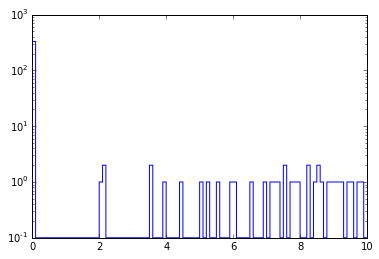

In [411]:
#x-match with the target list
goodspecsc = SkyCoord(goodspectaken['ra'], goodspectaken['dec'], unit=u.deg)
aentargssc = SkyCoord(aentargs['ra'], aentargs['dec'], unit=u.deg)
idx, d2d, _  = aentargssc.match_to_catalog_sky(goodspecsc)

plt.hist(d2d.arcsec, bins=100,range=(0,10),log=True,histtype='step')
alreadyobserved = d2d<1*u.arcsec
np.sum(alreadyobserved), np.sum(~alreadyobserved)

## Then do stuff 

In [412]:
!rm imacs_targets/Ae15B.cat imacs_targets/Ae15B_ini.obs
magellan.build_imacs_targeting_files(aen, 'Marchi/Munoz', targs=aentargs[~alreadyobserved], date='2015-9-5',
                                     refmagrange={'r':(17, 17.5)}, inclhost=False, onlygals=False)

Wrote catalog to imacs_targets/Ae15B.cat
Wrote obs file to imacs_targets/Ae15B_ini.obs


['imacs_targets/Ae15B_1.SMF', 'imacs_targets/Ae15B_2.SMF', 'imacs_targets/Ae15B_3.SMF', 'imacs_targets/Ae15B_4.SMF']
Total targets already observed= 489
Priority distribution of slitted targets:
Priority 1.0 : 37 targeted, 26 remaining: 58.7301587302 %
Priority 2.0 : 55 targeted, 28 remaining: 66.265060241 %
Priority 3.0 : 183 targeted, 143 remaining: 56.1349693252 %
Priority 4.0 : 214 targeted, 428 remaining: 33.3333333333 %
All priorities: 489 targeted, 625 remaining: 43.8958707361 %


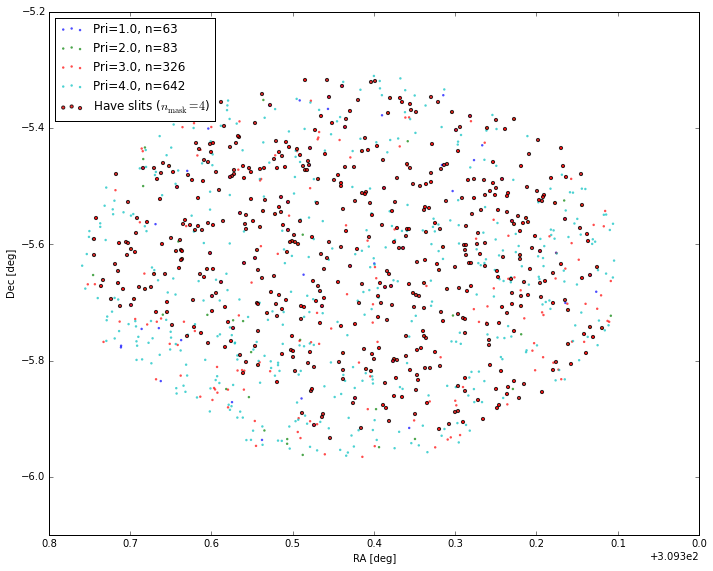

In [414]:
plt.figure(figsize=(10,8))
magellan.plot_imacs_masks(aen, eastleft=True, plotpris =True)
plt.tight_layout()